In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from hydra.utils import instantiate
from pingouin import multivariate_normality
import yaml
import json
import torch
from pathlib import Path
from functools import reduce, partial

from modules.utils import (
    remove_fx_parametrisation,
    get_chunks,
    vec2statedict,
)
from utils import get_log_mags_from_eq, Roystest

### Load presets, define helper functions

In [2]:
internal_folder = Path("presets/internal")
medleydb_folder = Path("presets/medleydb")
fx_config_path = internal_folder.parent / "fx_config.yaml"

with open(internal_folder / "info.json") as fp:
    info = json.load(fp)

# define how to convert a concated parmaeter vector to a model state dict
param_keys = info["params_keys"]
original_shapes = list(
    map(lambda lst: lst if len(lst) else [1], info["params_original_shapes"])
)

*vec2dict_args, dimensions_not_need = get_chunks(param_keys, original_shapes)
vec2dict_args = [param_keys, original_shapes] + vec2dict_args
vec2dict = partial(
    vec2statedict,
    **dict(
        zip(
            [
                "keys",
                "original_shapes",
                "selected_chunks",
                "position",
                "U_matrix_shape",
            ],
            vec2dict_args,
        )
    ),
)

# assume every run has the same config
with open(fx_config_path) as fp:
    fx_config = yaml.safe_load(fp)


def vec2model(x: torch.Tensor):
    model = instantiate(fx_config["model"])
    state_dict = vec2dict(x)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    remove_fx_parametrisation(model)
    return model


# load the raw (ground truth) parameters
features = np.load(internal_folder / "raw_params.npy")
train_indexes = np.load(internal_folder / "train_index.npy")
selected_features = np.delete(features, dimensions_not_need, axis=1)
internal_features = selected_features[train_indexes]
gaussians = np.load(internal_folder / "gaussian.npz")
internal_mu, internal_cov = gaussians["mean"], gaussians["cov"]

features = np.load(medleydb_folder / "raw_params.npy")
medleydb_features = np.delete(features, dimensions_not_need, axis=1)
gaussians = np.load(medleydb_folder / "gaussian.npz")
medleydb_mu, medleydb_cov = gaussians["mean"], gaussians["cov"]


# load the PCA model
def get_pca_stats(cov, truncate_after=None):
    eigenvalues, eigenvecs = np.linalg.eigh(cov)
    eigenvalues = np.flip(eigenvalues, 0)
    eigenvecs = np.flip(eigenvecs, 1)
    if truncate_after is not None:
        eigenvalues = eigenvalues[:truncate_after]
        eigenvecs = eigenvecs[:, :truncate_after]

    explained_variance_ratio_ = eigenvalues / eigenvalues.sum()
    return eigenvalues, eigenvecs, explained_variance_ratio_


def pca_transform(mu, U, e, x, whiten=False):
    return (x - mu) @ U.T / (np.sqrt(e) if whiten else 1)


def pca_inverse_transform(mu, U, e, x, whiten=False):
    return (x * (np.sqrt(e) if whiten else 1)) @ U + mu
    # return mu + x @ components_


internal_e, internal_Ut, internal_explained_variance_ratio_ = get_pca_stats(internal_cov)
internal_U = internal_Ut.T
internal_pca = partial(pca_transform, internal_mu, internal_U, internal_e, whiten=True)
internal_inverse_pca = partial(
    pca_inverse_transform, internal_mu, internal_U, internal_e, whiten=True
)

medleydb_e, medleydb_Ut, medleydb_explained_variance_ratio_ = get_pca_stats(
    medleydb_cov, truncate_after=medleydb_features.shape[0] - 1
)
medleydb_U = medleydb_Ut.T
medleydb_pca = partial(pca_transform, medleydb_mu, medleydb_U, medleydb_e, whiten=True)
medleydb_inverse_pca = partial(
    pca_inverse_transform, medleydb_mu, medleydb_U, medleydb_e, whiten=True
)

internal_transformed = internal_pca(internal_features)
internal_recon = internal_inverse_pca(internal_transformed)

## Multivariate normality tests

In [3]:
print(f"Roys test p-value: {Roystest(internal_transformed[:, :74])[1]}")
print(f"HZ test p-value: {multivariate_normality(internal_transformed[:, :74]).pval}")

Roys test p-value: 0.0
HZ test p-value: 0.0


## Visualise correlation matrices

130 46


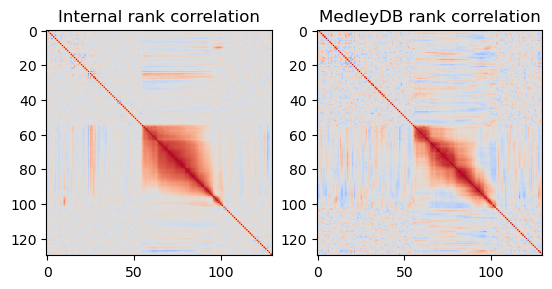

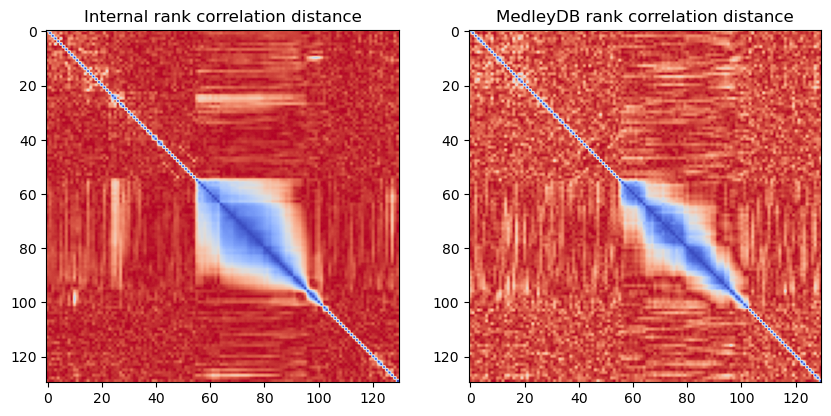

In [4]:
selected_chunks = vec2dict_args[2]
repeated_keys = sum(
    [
        ([f"{k}.{i}" for i in range(s)] if s > 1 else [k])
        for k, s in zip(param_keys, selected_chunks)
    ],
    [],
)
print(len(repeated_keys), len(param_keys))


internal_ranks = rankdata(internal_features, axis=0)
medleydb_ranks = rankdata(medleydb_features, axis=0)

internal_rank_corr = np.corrcoef(internal_ranks, rowvar=False)
medleydb_rank_corr = np.corrcoef(medleydb_ranks, rowvar=False)

plt.subplot(1, 2, 1)
plt.title("Internal rank correlation")
plt.imshow(internal_rank_corr, cmap="coolwarm", vmax=1, vmin=-1)
plt.subplot(1, 2, 2)
plt.title("MedleyDB rank correlation")
plt.imshow(medleydb_rank_corr, cmap="coolwarm", vmax=1, vmin=-1)
plt.show()


distance = 1 - np.abs(internal_rank_corr)
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Internal rank correlation distance")
plt.imshow(distance, cmap="coolwarm")
plt.subplot(1, 2, 2)
plt.title("MedleyDB rank correlation distance")
plt.imshow(1 - np.abs(medleydb_rank_corr), cmap="coolwarm")
plt.show()
# linkage_matrix = linkage(squareform(distance), method="ward")
# plt.figure(figsize=(10, 5))
# dendrogram(
#     linkage_matrix, labels=repeated_keys, orientation="top", p=2, truncate_mode="level"
# )
# plt.show()

## Visualise effect-wise correlations

This corresponds to Figure 5 in the preprint.

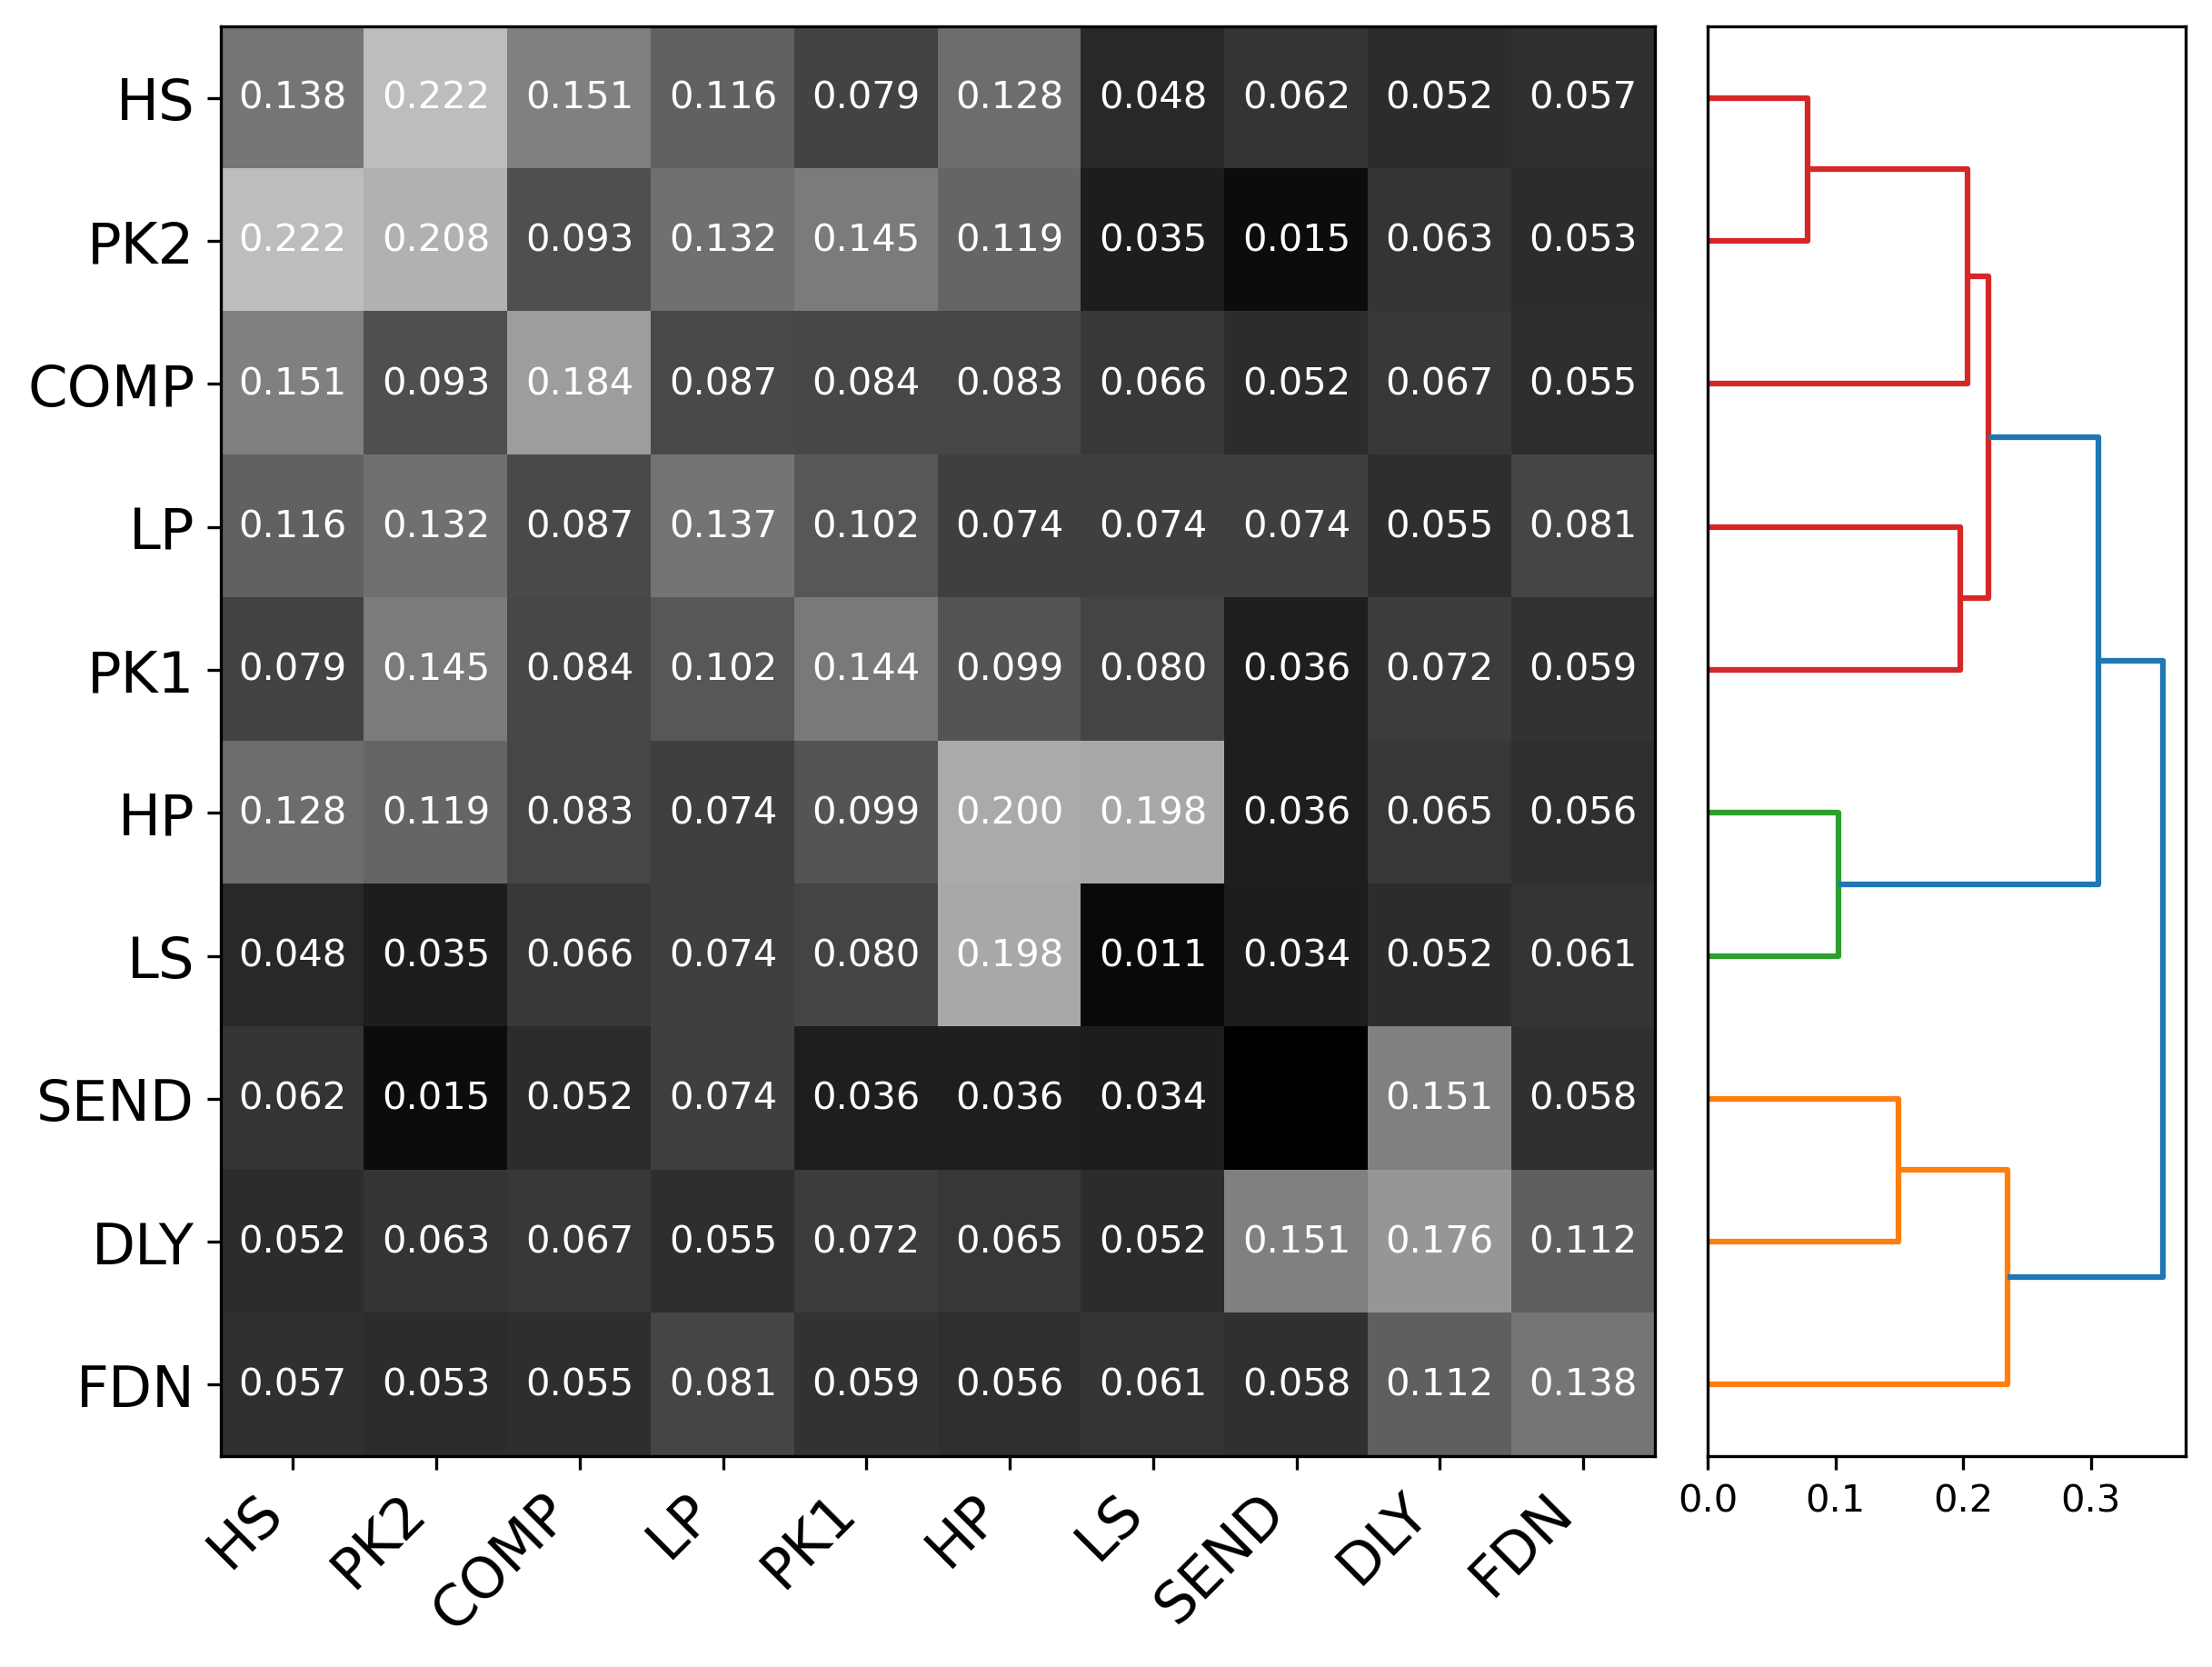

In [5]:
# These are calculated in the public google spreadsheet
csv_str = """0.144	0.145	0.080	0.079	0.102	0.099	0.084	0.072	0.059	0.036
	0.208	0.035	0.222	0.132	0.119	0.093	0.063	0.053	0.015
		0.011	0.048	0.074	0.198	0.066	0.052	0.061	0.034
			0.138	0.116	0.128	0.151	0.052	0.057	0.062
				0.137	0.074	0.087	0.055	0.081	0.074
					0.200	0.083	0.065	0.056	0.036
						0.184	0.067	0.055	0.052
							0.176	0.112	0.151
								0.138	0.058
									"""
raw = [line.split("\t") for line in csv_str.split("\n")]
data = np.array([[float(xx) if len(xx) else 0 for xx in x] for x in raw])
data = data + np.triu(data, k=1).T


labels = ["PK1", "PK2", "LS", "HS", "LP", "HP", "COMP", "DLY", "FDN", "SEND"]
fig, ax = plt.subplots(
    1,
    2,
    figsize=(8, 6),
    dpi=300,
    width_ratios=[3, 1],
    # height_ratios=[1],
    constrained_layout=True,
)
# adjust the subplot ratio to be 3:1

distance = 1 - data - 0.7
distance[np.diag_indices(distance.shape[0])] = 0
Z = linkage(squareform(distance), method="ward")
d = dendrogram(
    Z, labels=labels, orientation="right", ax=ax[1], leaf_font_size=15, no_labels=True,
)
sorted_labels = d["ivl"][::-1]
sorted_index = [labels.index(l) for l in sorted_labels]
data = data[sorted_index][:, sorted_index]

im = ax[0].imshow(data.T, vmin=0, vmax=0.3, cmap="gray", aspect="auto")
ax[0].set_xticks(
    np.arange(len(labels)), labels=sorted_labels, rotation=45, ha="right", size=15
)
ax[0].set_yticks(np.arange(len(labels)), labels=sorted_labels, size=15)

for i in range(data.shape[0]):
    # for j in range(min(i+1, data.shape[1] - 1)):
    for j in range(data.shape[1]):
        if data[j, i] == 0:
            continue
        ax[0].text(
            j, i, f"{data[j, i]:.3f}", ha="center", va="center", color="w", size=10
        )
plt.show()

## Cumulative percentage of total variance (CPV)

This corresponds to Figure 2 in the preprint.

Internal needs at least 59.23% components to cover 99% variance.
MedleyDB needs at least 65.22% components to cover 99% variance.
MedleyDB on Internal's PCA needs at least 76.92% components to cover 99% variance.


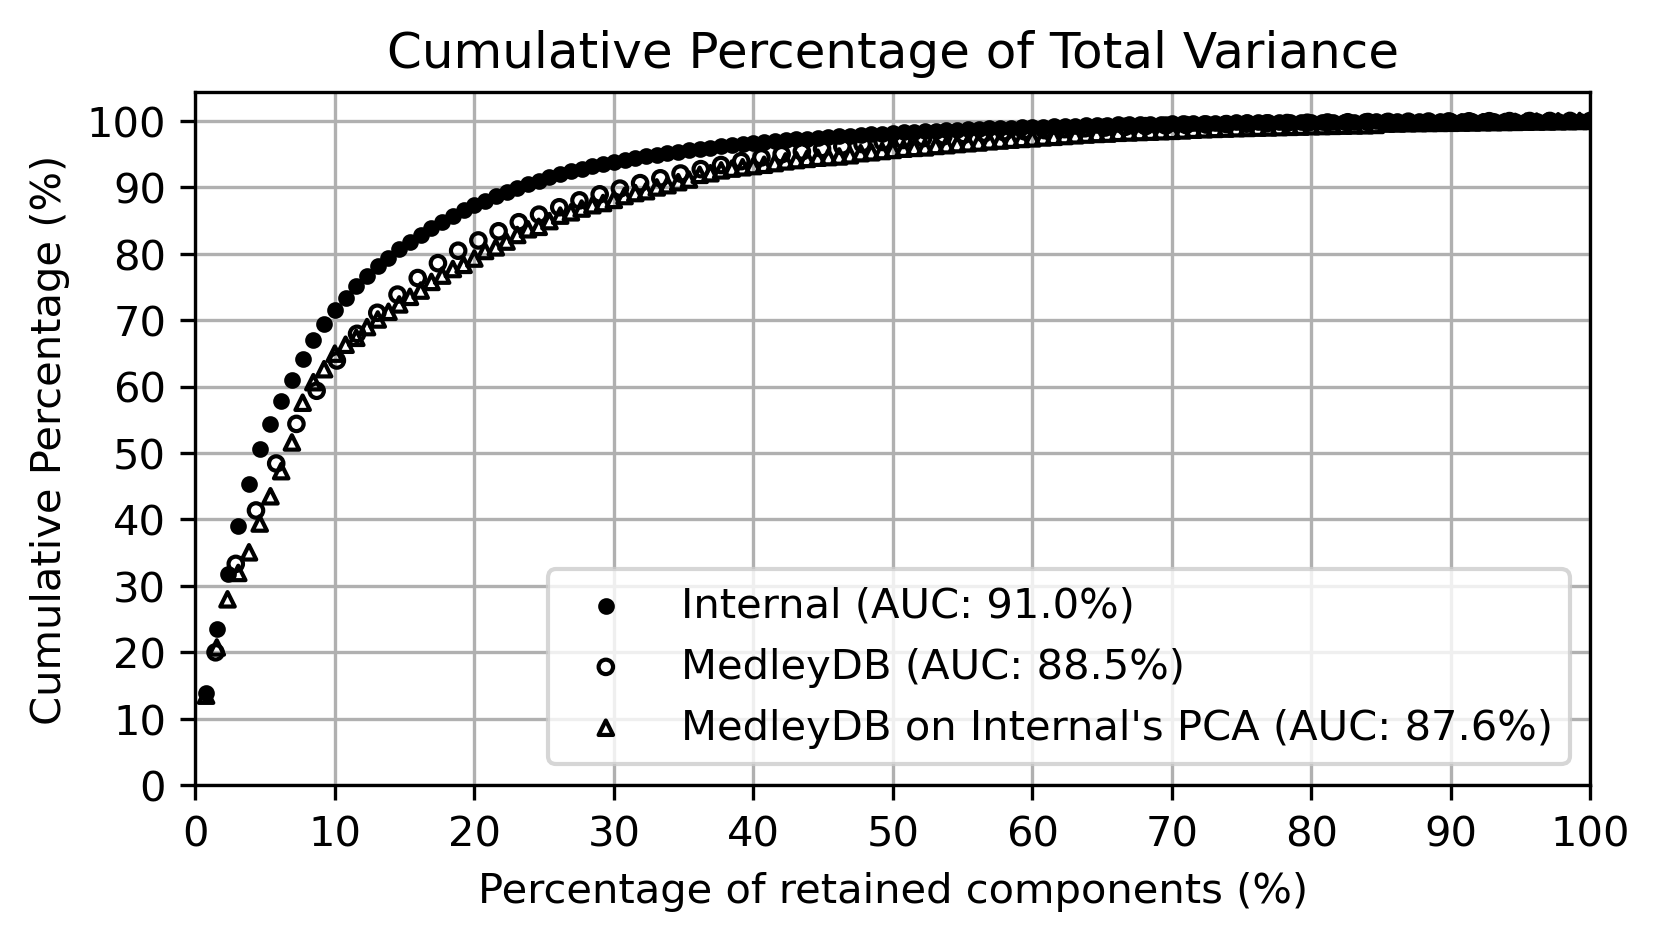

In [6]:
medleydb_transformed2internal = internal_pca(medleydb_features) * np.sqrt(internal_e)
medleydb2internal_var = np.mean(np.square(medleydb_transformed2internal), axis=0)
medleydb2internal_cum_var = (
    np.cumsum(medleydb2internal_var) / np.sum(medleydb2internal_var) * 100
)

internal_cum_var = np.cumsum(internal_explained_variance_ratio_) * 100
medleydb_cum_var = np.cumsum(medleydb_explained_variance_ratio_) * 100
print(
    f"Internal needs at least {(np.where(internal_cum_var > 99)[0][0] + 1)/internal_cum_var.size * 100:.2f}% components to cover 99% variance."
)
print(
    f"MedleyDB needs at least {(np.where(medleydb_cum_var > 99)[0][0] + 1)/medleydb_cum_var.size * 100:.2f}% components to cover 99% variance."
)
print(
    f"MedleyDB on Internal's PCA needs at least {(np.where(medleydb2internal_cum_var > 99)[0][0] + 1)/medleydb2internal_cum_var.size * 100:.2f}% components to cover 99% variance."
)

fig = plt.figure(figsize=(6, 3), dpi=300)
plt.title("Cumulative Percentage of Total Variance")
plt.xlabel("Percentage of retained components (%)")
plt.ylabel("Cumulative Percentage (%)")
plt.scatter(
    (np.arange(internal_cum_var.shape[0]) + 1) / internal_cum_var.shape[0] * 100,
    internal_cum_var,
    label=f"Internal (AUC: {(internal_cum_var.sum() + internal_cum_var[:-1].sum()) * 0.5 / internal_cum_var.shape[0]:.1f}%)",
    marker=".",
    c="black",
    zorder=10,
)
plt.scatter(
    (np.arange(medleydb_cum_var.shape[0]) + 1) / medleydb_cum_var.shape[0] * 100,
    medleydb_cum_var,
    label=f"MedleyDB (AUC: {(medleydb_cum_var.sum() + medleydb_cum_var[:-1].sum()) * 0.5 / medleydb_cum_var.shape[0]:.1f}%)",
    marker="o",
    edgecolors="black",
    facecolors="none",
    s=12,
    zorder=10,
)
plt.scatter(
    (np.arange(medleydb2internal_cum_var.shape[0]) + 1)
    / medleydb2internal_cum_var.shape[0]
    * 100,
    medleydb2internal_cum_var,
    label=f"MedleyDB on Internal's PCA (AUC: {(medleydb2internal_cum_var.sum() + medleydb2internal_cum_var[:-1].sum()) * 0.5 / medleydb2internal_cum_var.shape[0]:.1f}%)",
    marker="^",
    edgecolors="black",
    facecolors="none",
    s=12,
    zorder=10,
)

plt.xlim(0, 100)
legend = plt.legend(loc="lower right")
plt.xticks(np.arange(0, 101, 10))
# y-axis: every 10th value
plt.yticks(np.arange(0, 101, 10))
plt.grid(True, zorder=0)
plt.show()

## PCA projected data

This corresponds to Figure 6 in the preprint.

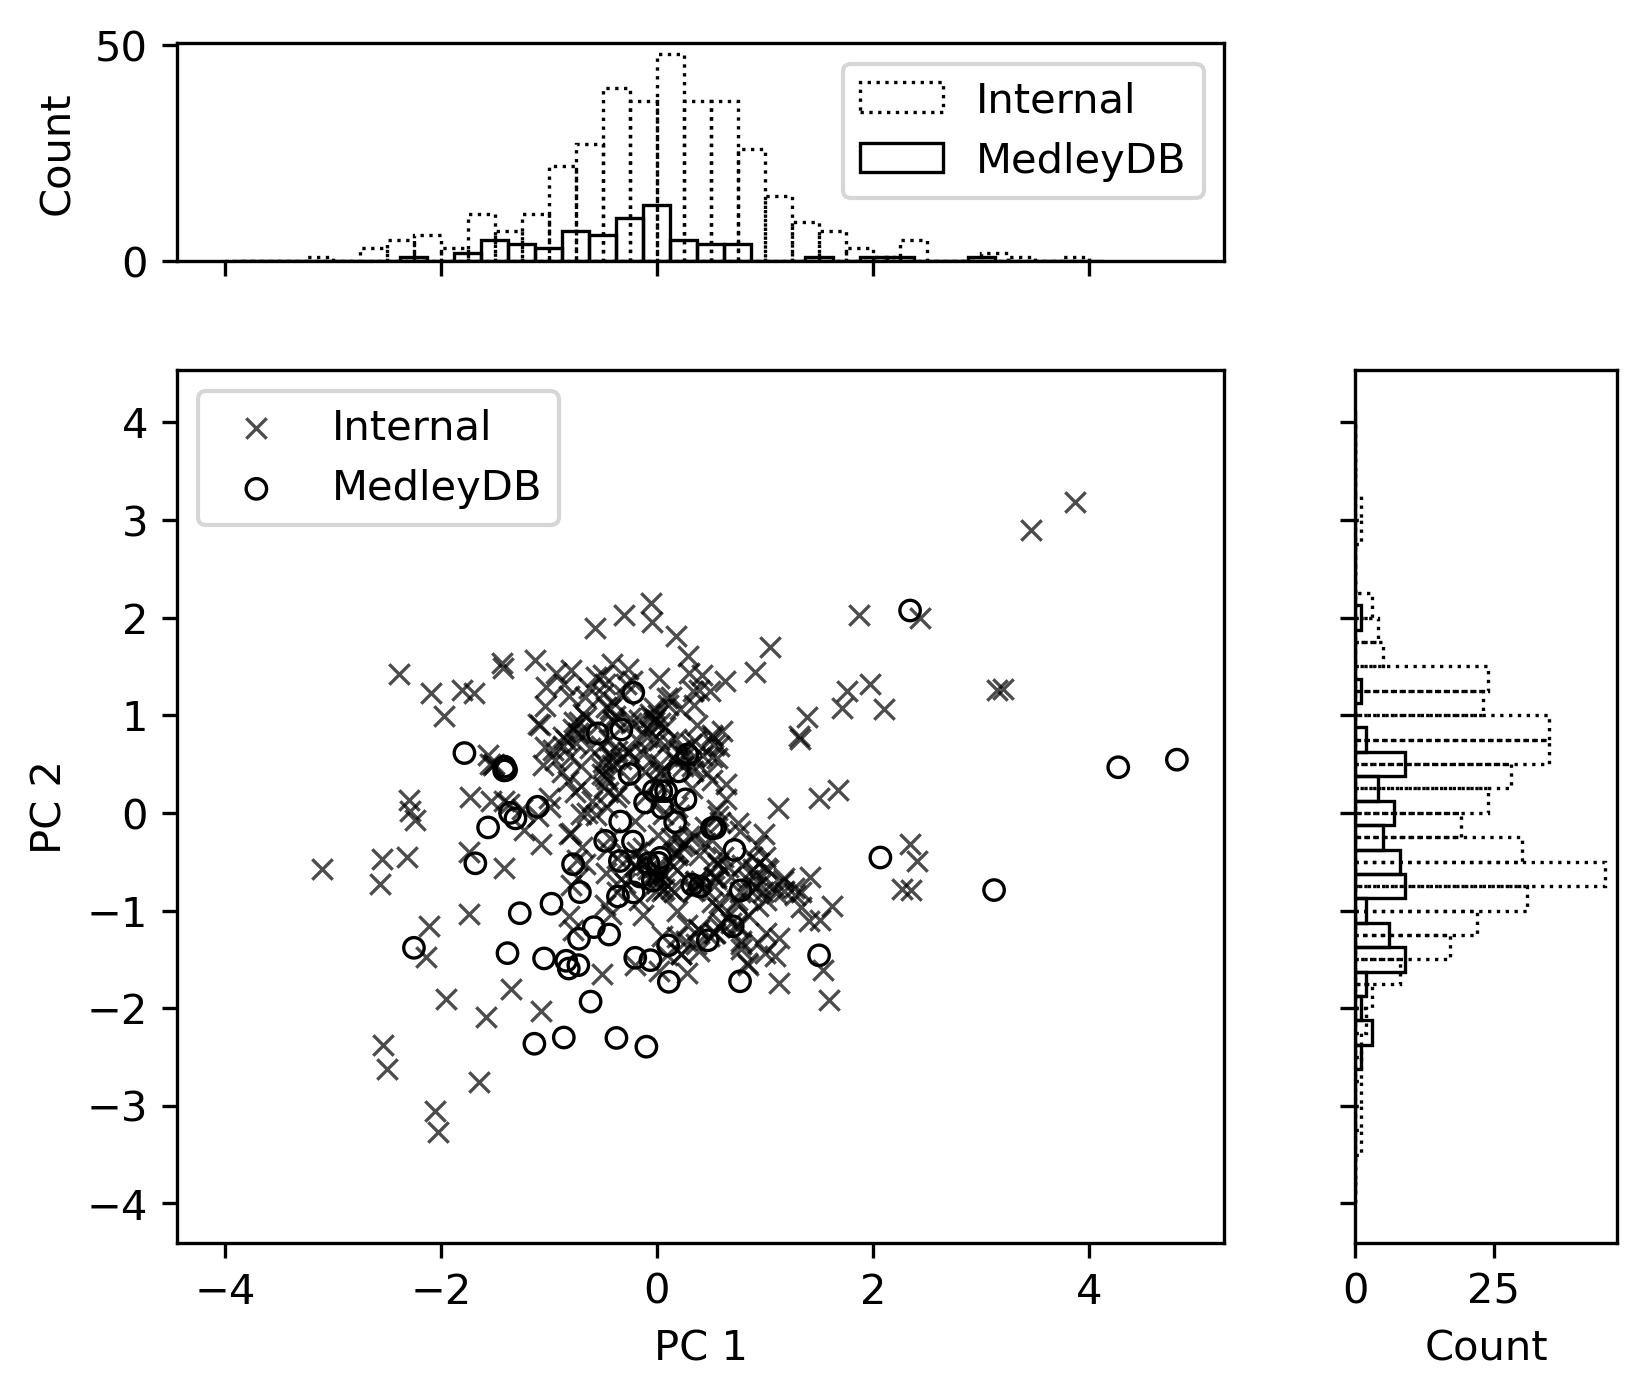

In [7]:
medley_transformed = internal_pca(medleydb_features)


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=0.5, s=8)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

    # now determine nice limits by hand:
    binwidth = 0.25  # * 10
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax / binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation="horizontal")


fig = plt.figure(figsize=(6, 5), dpi=300)
gs = fig.add_gridspec(
    2,
    2,
    width_ratios=(4, 1),
    height_ratios=(1, 4),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# the scatter plot:
ax.scatter(
    internal_transformed[:, 0],
    internal_transformed[:, 1],
    marker="x",
    c="black",
    linewidths=0.8,
    s=24,
    label="Internal",
    alpha=0.7,
)
ax.scatter(
    medley_transformed[:, 0],
    medley_transformed[:, 1],
    marker="o",
    facecolors="none",
    edgecolors="black",
    s=24,
    label="MedleyDB",
    linewidths=0.8,
)
ax.legend(loc="upper left")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# now determine nice limits by hand:
binwidth = 0.25  # * 10
xymax = np.max(np.abs(internal_transformed[:, :2]))
lim = (int(xymax / binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)

style = {"facecolor": "none", "edgecolor": "black", "linewidth": 0.8}

ax_histx.hist(internal_transformed[:, 0], bins=bins, density=False, linestyle=":", label="Internal",
              **style)
ax_histx.hist(
    medley_transformed[:, 0],
    bins=bins + binwidth / 2,
    density=False,
    linestyle="-",
    label="MedleyDB",
    **style
)

ax_histy.hist(
    internal_transformed[:, 1],
    bins=bins,
    orientation="horizontal",
    density=False,
    linestyle=":",
    **style
)
ax_histy.hist(
    medley_transformed[:, 1],
    bins=bins + binwidth / 2,
    orientation="horizontal",
    density=False,
    linestyle="-",
    **style
)

ax_histx.set_ylabel("Count")
ax_histy.set_xlabel("Count")

ax_histx.legend(loc="upper right")

plt.show()

## Visualise the principal components

Corresponds to Figure 3 in the preprint.

/Users/ycy/Documents/diffvox/utils.py:38: RuntimeWarning: divide by zero encountered in log10
  log_h = 20 * np.log10(np.abs(h))


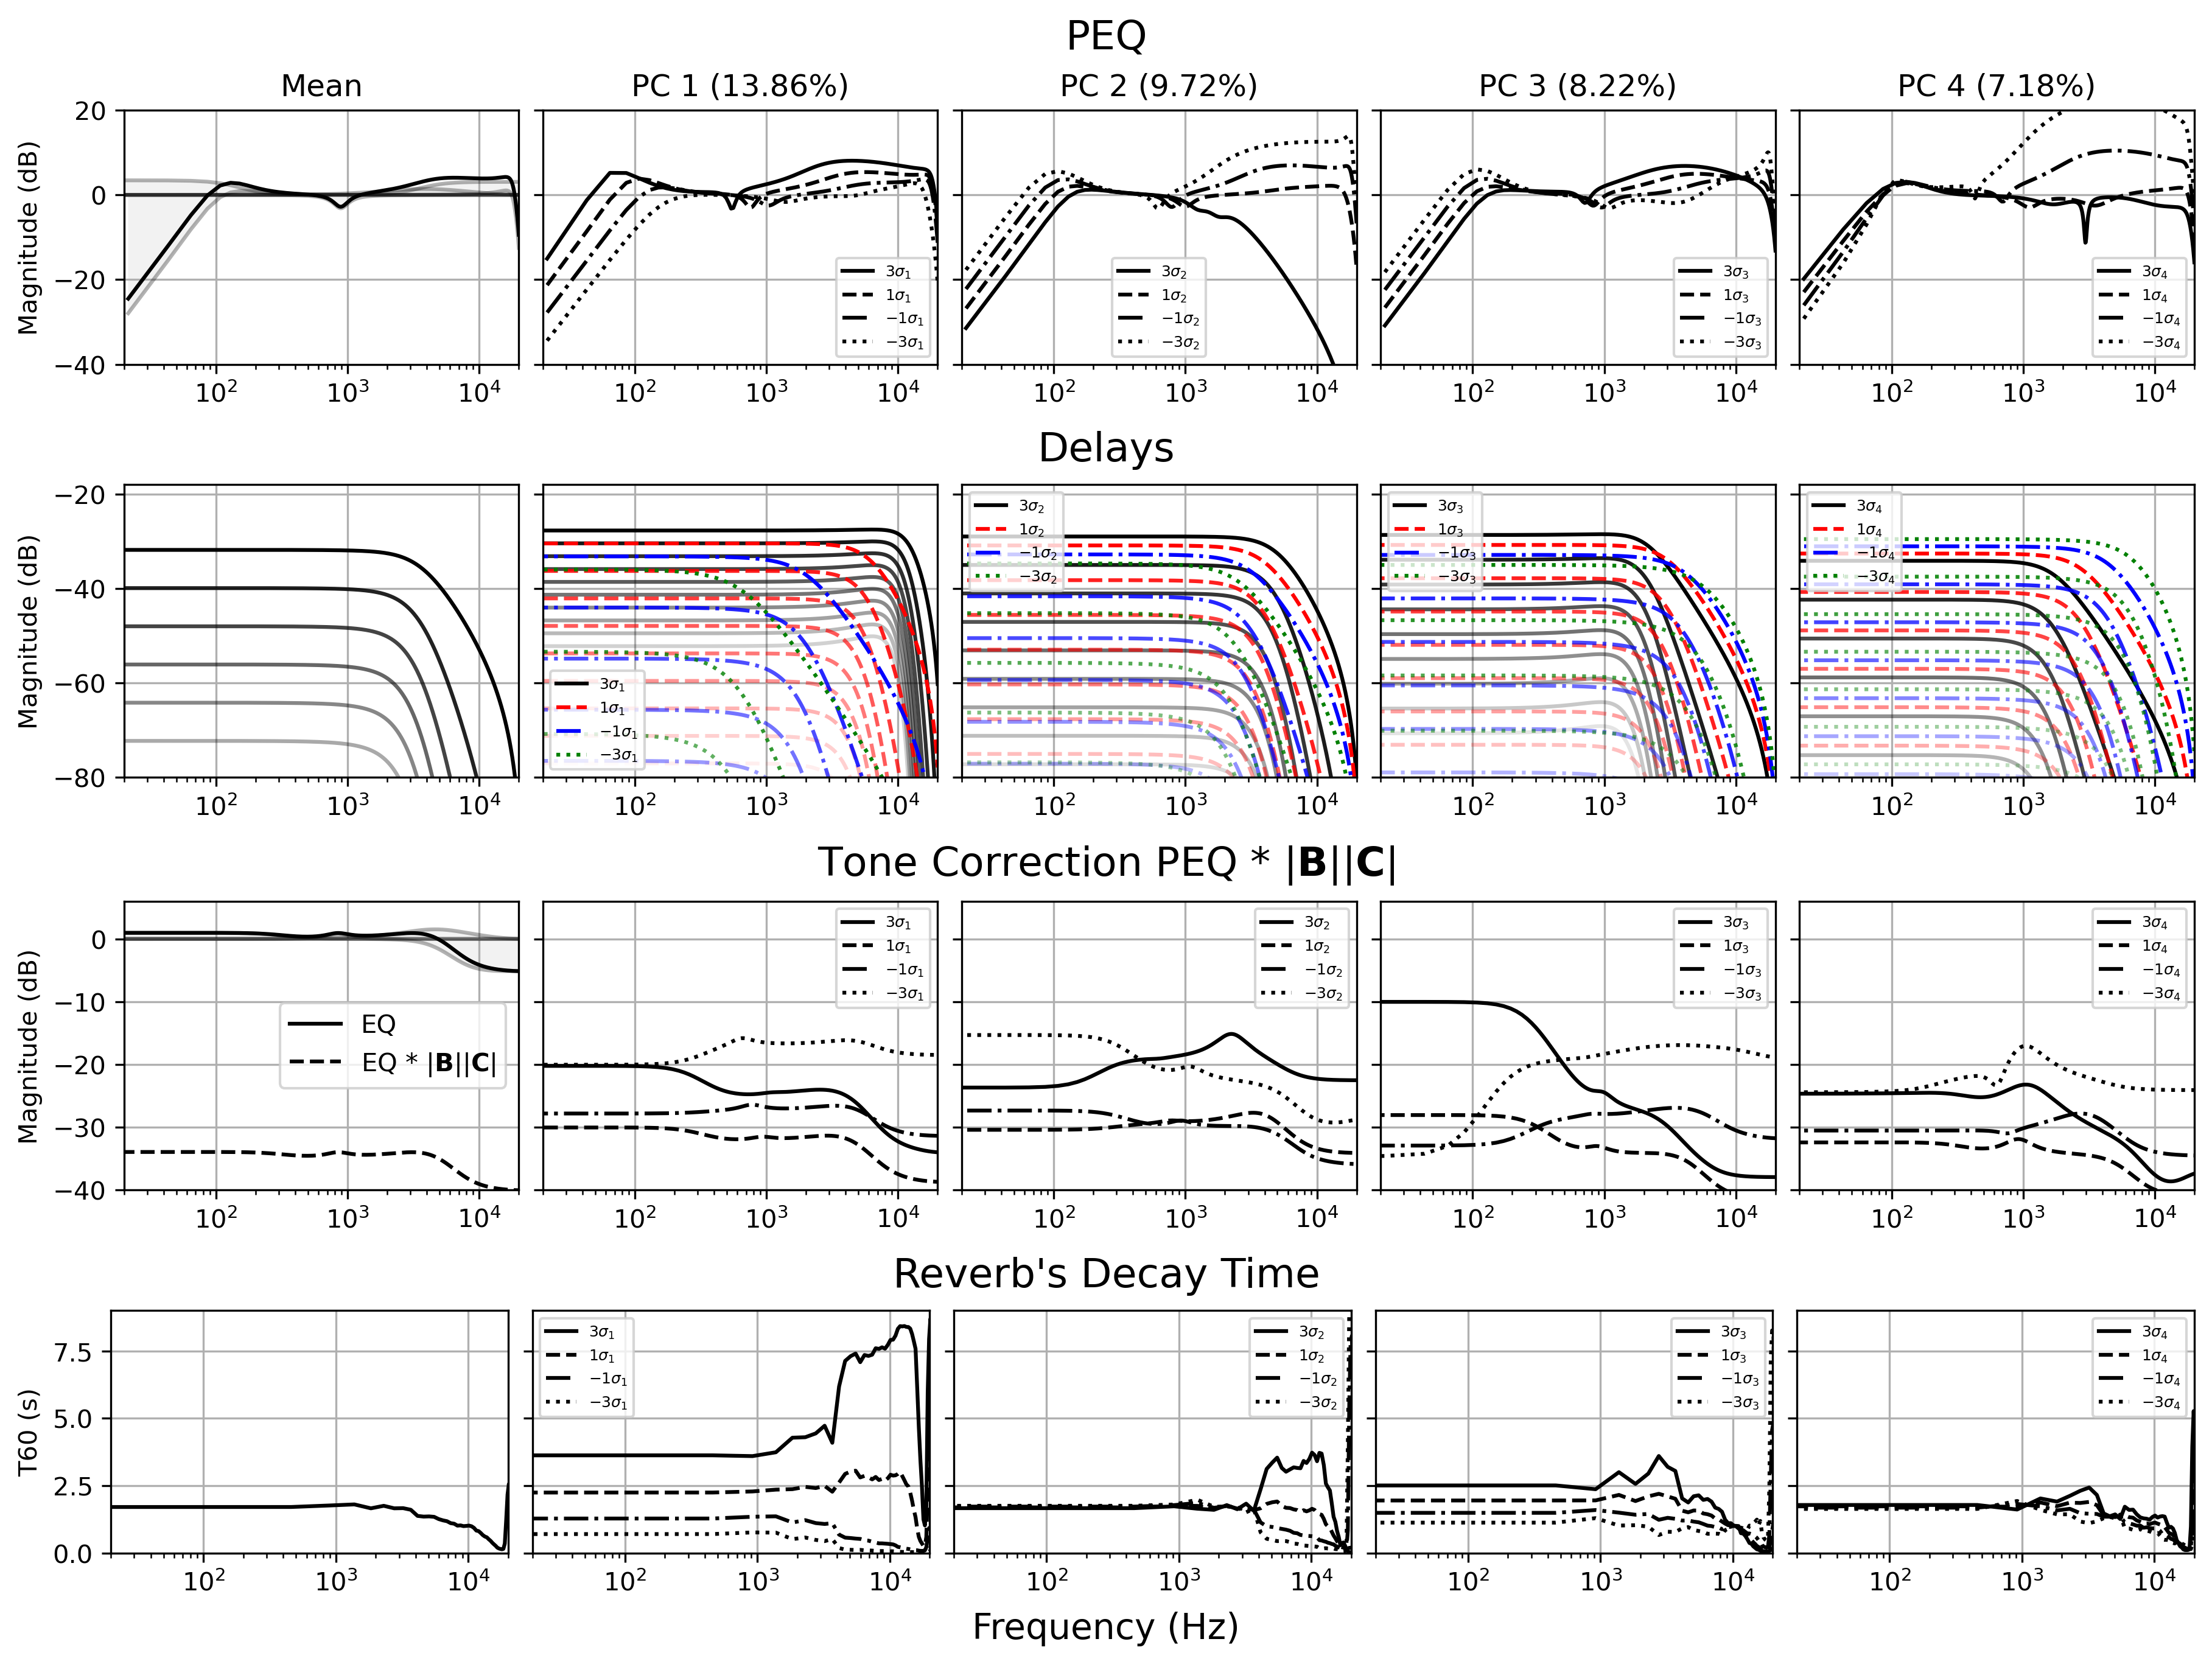

In [8]:
def plot_eq(ax, fx_model, label, color, linestyle="-", plot_individual=False):
    w, eq_log_mags = get_log_mags_from_eq(fx_model[:6])
    ax.plot(w, sum(eq_log_mags), label=label, color=color, linestyle=linestyle)
    if plot_individual:
        for i, eq_log_mag in enumerate(eq_log_mags):
            ax.plot(w, eq_log_mag, "k-", alpha=0.3)
            ax.fill_between(
                w, eq_log_mag, 0, facecolor="gray", edgecolor="none", alpha=0.1
            )


def plot_reverb(
    ax, fdn, label, color, linestyle="-", plus_bs=True, plot_individual=False
):
    w, eq_log_mags = get_log_mags_from_eq(fdn.eq)
    if plus_bs:
        bc = fdn.params.c.norm() * fdn.params.b.norm() #/ fdn.params.U.norm()
        # bc = (fdn.params.c @ torch.linalg.inv(fdn.params.U) @ fdn.params.b).norm()
        log_bc = torch.log10(bc).item() * 20
        eq_log_mags = [x + log_bc / len(eq_log_mags) for x in eq_log_mags]
    ax.plot(w, sum(eq_log_mags), label=label, color=color, linestyle=linestyle)
    if plot_individual:
        for i, eq_log_mag in enumerate(eq_log_mags):
            ax.plot(w, eq_log_mag, "k-", alpha=0.3)
            ax.fill_between(
                w, eq_log_mag, 0, facecolor="gray", edgecolor="none", alpha=0.1
            )


def plot_delay(
    ax, delay, label, color, linestyle="-", plot_individual=False, decay_num=10
):
    w, eq_log_mags = get_log_mags_from_eq([delay.eq])
    log_gain = delay.params.gain.log10().item() * 20
    d = delay.params.delay.item() / 1000
    log_mag = sum(eq_log_mags)
    ax.plot(w, log_mag + log_gain, label=label, color=color, linestyle=linestyle)
    if plot_individual:
        log_feedback = delay.params.feedback.log10().item() * 20
        for i in range(1, decay_num):
            feedback_log_mag = log_mag * (i + 1) + log_feedback * i + log_gain
            ax.plot(
                w,
                feedback_log_mag,
                c=color,
                alpha=max(0, (decay_num - i * d * 4) / decay_num),
                linestyle=linestyle,
            )


@torch.no_grad()
def plot_gamma(ax, fdn, label, color, linestyle="-"):
    gamma = fdn.params.gamma.squeeze().numpy()
    delays = fdn.delays.numpy()
    w = np.linspace(0, 22050, gamma.size)
    t60 = -60 / (20 * np.log10(gamma) / np.min(delays)) / 44100
    ax.plot(w, t60, label=label, color=color, linestyle=linestyle)


fig = plt.figure(figsize=(12, 9), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(4, 1)
ax = [subfig.subplots(1, 5, sharex="row", sharey="row") for subfig in subfigs]

subfigs[0].suptitle("PEQ", size=16)
subfigs[1].suptitle("Delays", size=16)
subfigs[2].suptitle("Tone Correction PEQ * $|\mathbf{B}||\mathbf{C}|$", size=16)
subfigs[3].suptitle("Reverb's Decay Time", size=16)

mu_model = vec2model(torch.from_numpy(internal_mu))
plot_eq(ax[0][0], mu_model, "Mean", "black", plot_individual=True)
plot_delay(
    ax[1][0],
    mu_model[7].effects[0],
    "Delay",
    "black",
    plot_individual=True,
    decay_num=10,
)
plot_reverb(
    ax[2][0],
    mu_model[7].effects[1],
    "EQ",
    "black",
    plus_bs=False,
    linestyle="-",
    plot_individual=True,
)
plot_reverb(
    ax[2][0],
    mu_model[7].effects[1],
    "EQ * $|\mathbf{B}||\mathbf{C}|$",
    "black",
    plus_bs=True,
    linestyle="--",
)
plot_gamma(ax[3][0], mu_model[7].effects[1], "Gamma", "black")


weights = [3, 1, -1, -3]
for i, pc in enumerate(internal_U[:4] * np.sqrt(internal_e[:4, None])):
    for ls, c, w in zip(
        ["-", "--", "-.", ":"], ["black", "red", "blue", "green"], weights
    ):
        pc_model = vec2model(torch.from_numpy(internal_mu + w * pc))
        plot_eq(ax[0][i + 1], pc_model, f"${w}\sigma_{{{i+1}}}$", "black", linestyle=ls)
        plot_delay(
            ax[1][i + 1],
            pc_model[7].effects[0],
            f"${w}\sigma_{{{i+1}}}$",
            c,
            linestyle=ls,
            plot_individual=True,
            decay_num=10,
        )
        plot_reverb(
            ax[2][i + 1],
            pc_model[7].effects[1],
            f"${w}\sigma_{{{i+1}}}$",
            "black",
            linestyle=ls,
        )
        plot_gamma(
            ax[3][i + 1],
            pc_model[7].effects[1],
            f"${w}\sigma_{{{i+1}}}$",
            "black",
            linestyle=ls,
        )

ax[0][0].set_xscale("log")
ax[0][0].set_xlim(20, 20000)
ax[0][0].set_ylim(-40, 20)
ax[0][0].set_ylabel("Magnitude (dB)")
ax[0][0].set_title("Mean")

ax[1][0].set_xscale("log")
ax[1][0].set_xlim(20, 20000)
ax[1][0].set_ylim(-80, -18)
ax[1][0].set_ylabel("Magnitude (dB)")

ax[2][0].legend()
ax[2][0].set_xscale("log")
ax[2][0].set_xlim(20, 20000)
ax[2][0].set_ylim(-40, 6)
ax[2][0].set_ylabel("Magnitude (dB)")

ax[3][0].set_xscale("log")
ax[3][0].set_xlim(20, 20000)
ax[3][0].set_ylim(0, 9)
ax[3][0].set_ylabel("T60 (s)")

for i in range(5):
    for j in range(4):
        if i:
            ax[j][i].legend(fontsize=6)
            if j == 0:
                ax[j][i].set_title(
                    f"PC {i} ({internal_explained_variance_ratio_[i-1]*100:.2f}%)"
                )
subfigs[-1].supxlabel("Frequency (Hz)", size=14)

for i in range(4):
    for j in range(5):
        ax[i][j].grid()

plt.show()

## Compression curves

This corresponds to Figure 7 in the preprint.

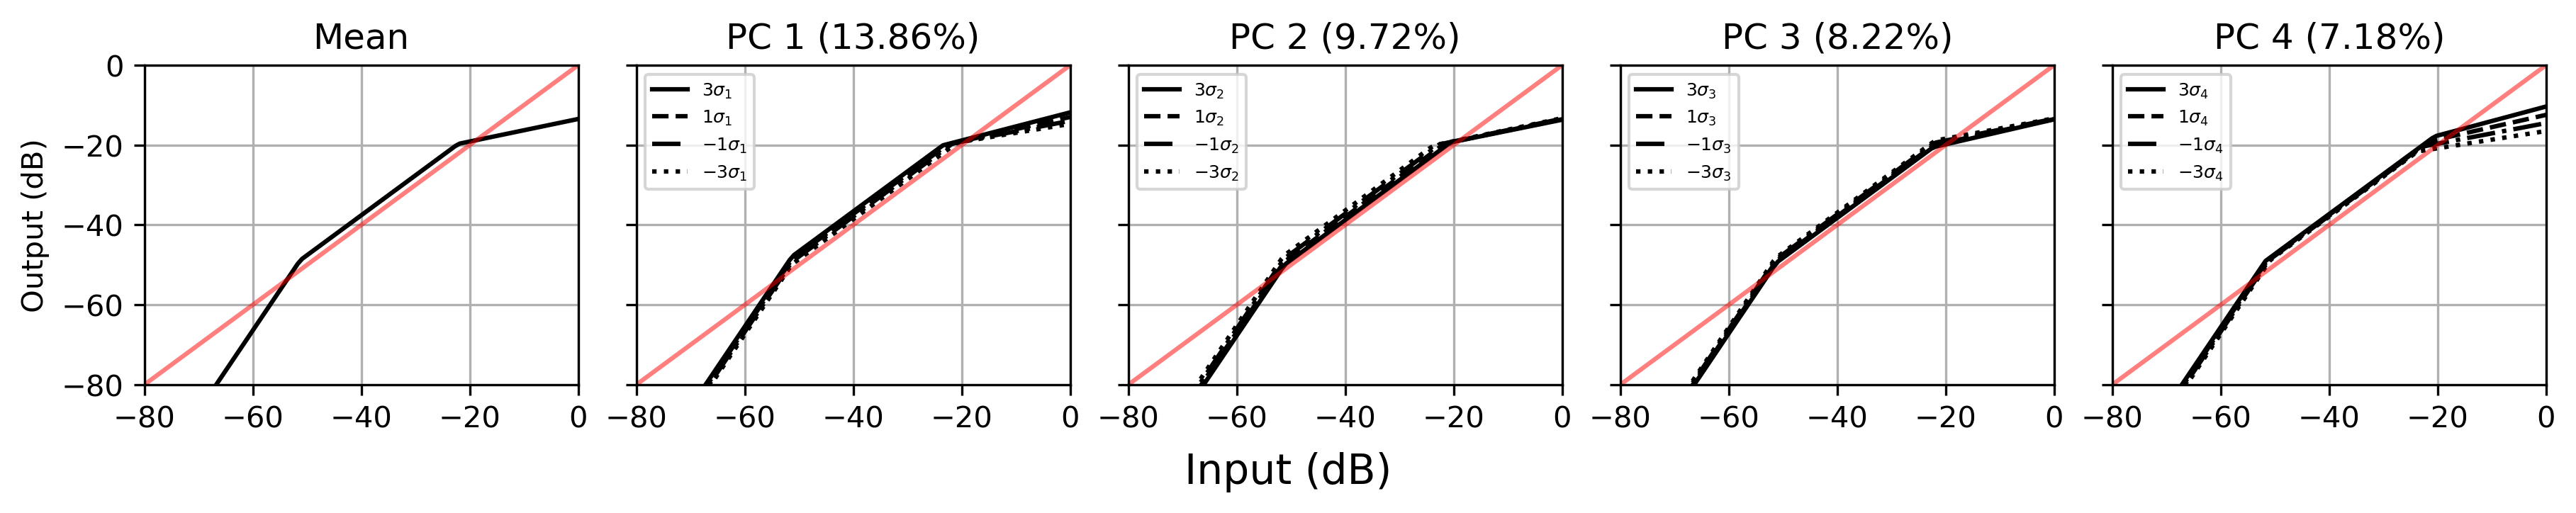

In [9]:
@torch.no_grad()
def plot_comp(ax, comp, label, color, linestyle="-"):
    cmp_th = comp.params.cmp_th.item()
    exp_th = comp.params.exp_th.item()
    cmp_ratio = comp.params.cmp_ratio.item()
    exp_ratio = comp.params.exp_ratio.item()
    make_up = comp.params.make_up.item()
    # print(cmp_ratio, cmp_th, exp_ratio, exp_th, make_up)

    comp_in = np.linspace(-80, 0, 100)
    comp_curve = np.where(
        comp_in > cmp_th,
        comp_in - (comp_in - cmp_th) * (cmp_ratio - 1) / cmp_ratio,
        comp_in,
    )
    comp_out = (
        np.where(
            comp_curve < exp_th,
            comp_curve - (exp_th - comp_curve) / exp_ratio,
            comp_curve,
        )
        + make_up
    )
    ax.plot(comp_in, comp_out, c=color, linestyle=linestyle, label=label)


fig, ax = plt.subplots(
    1, 5, figsize=(12, 2.3), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
mu_model = vec2model(torch.from_numpy(internal_mu))
plot_comp(ax[0], mu_model[6], "Comp", "black")
for i, pc in enumerate(internal_U[:4] * np.sqrt(internal_e[:4, None])):
    for ls, w in zip(["-", "--", "-.", ":"], weights):
        pc_model = vec2model(torch.from_numpy(internal_mu + w * pc))
        plot_comp(
            ax[i + 1], pc_model[6], f"${w}\sigma_{{{i+1}}}$", "black", linestyle=ls
        )

ax[0].set_ylabel("Output (dB)")
ax[0].set_title("Mean")
for i in range(0, 5):
    ax[i].set_xlim(-80, 0)
    ax[i].set_ylim(-80, 0)
    if i > 0:
        ax[i].set_title(f"PC {i} ({internal_explained_variance_ratio_[i-1]*100:.2f}%)")
        ax[i].legend(fontsize=6)
    ax[i].grid()
    ax[i].plot(np.linspace(-80, 0, 100), np.linspace(-80, 0, 100), c="r", alpha=0.5)
fig.supxlabel("Input (dB)", size=14)
plt.show()

## Histograms of some scalar parameters

This corresponds to Figure 4 in the preprint.

In [10]:
internal_models = [vec2model(torch.from_numpy(x)) for x in internal_features]
medley_models = [vec2model(torch.from_numpy(x)) for x in medleydb_features]

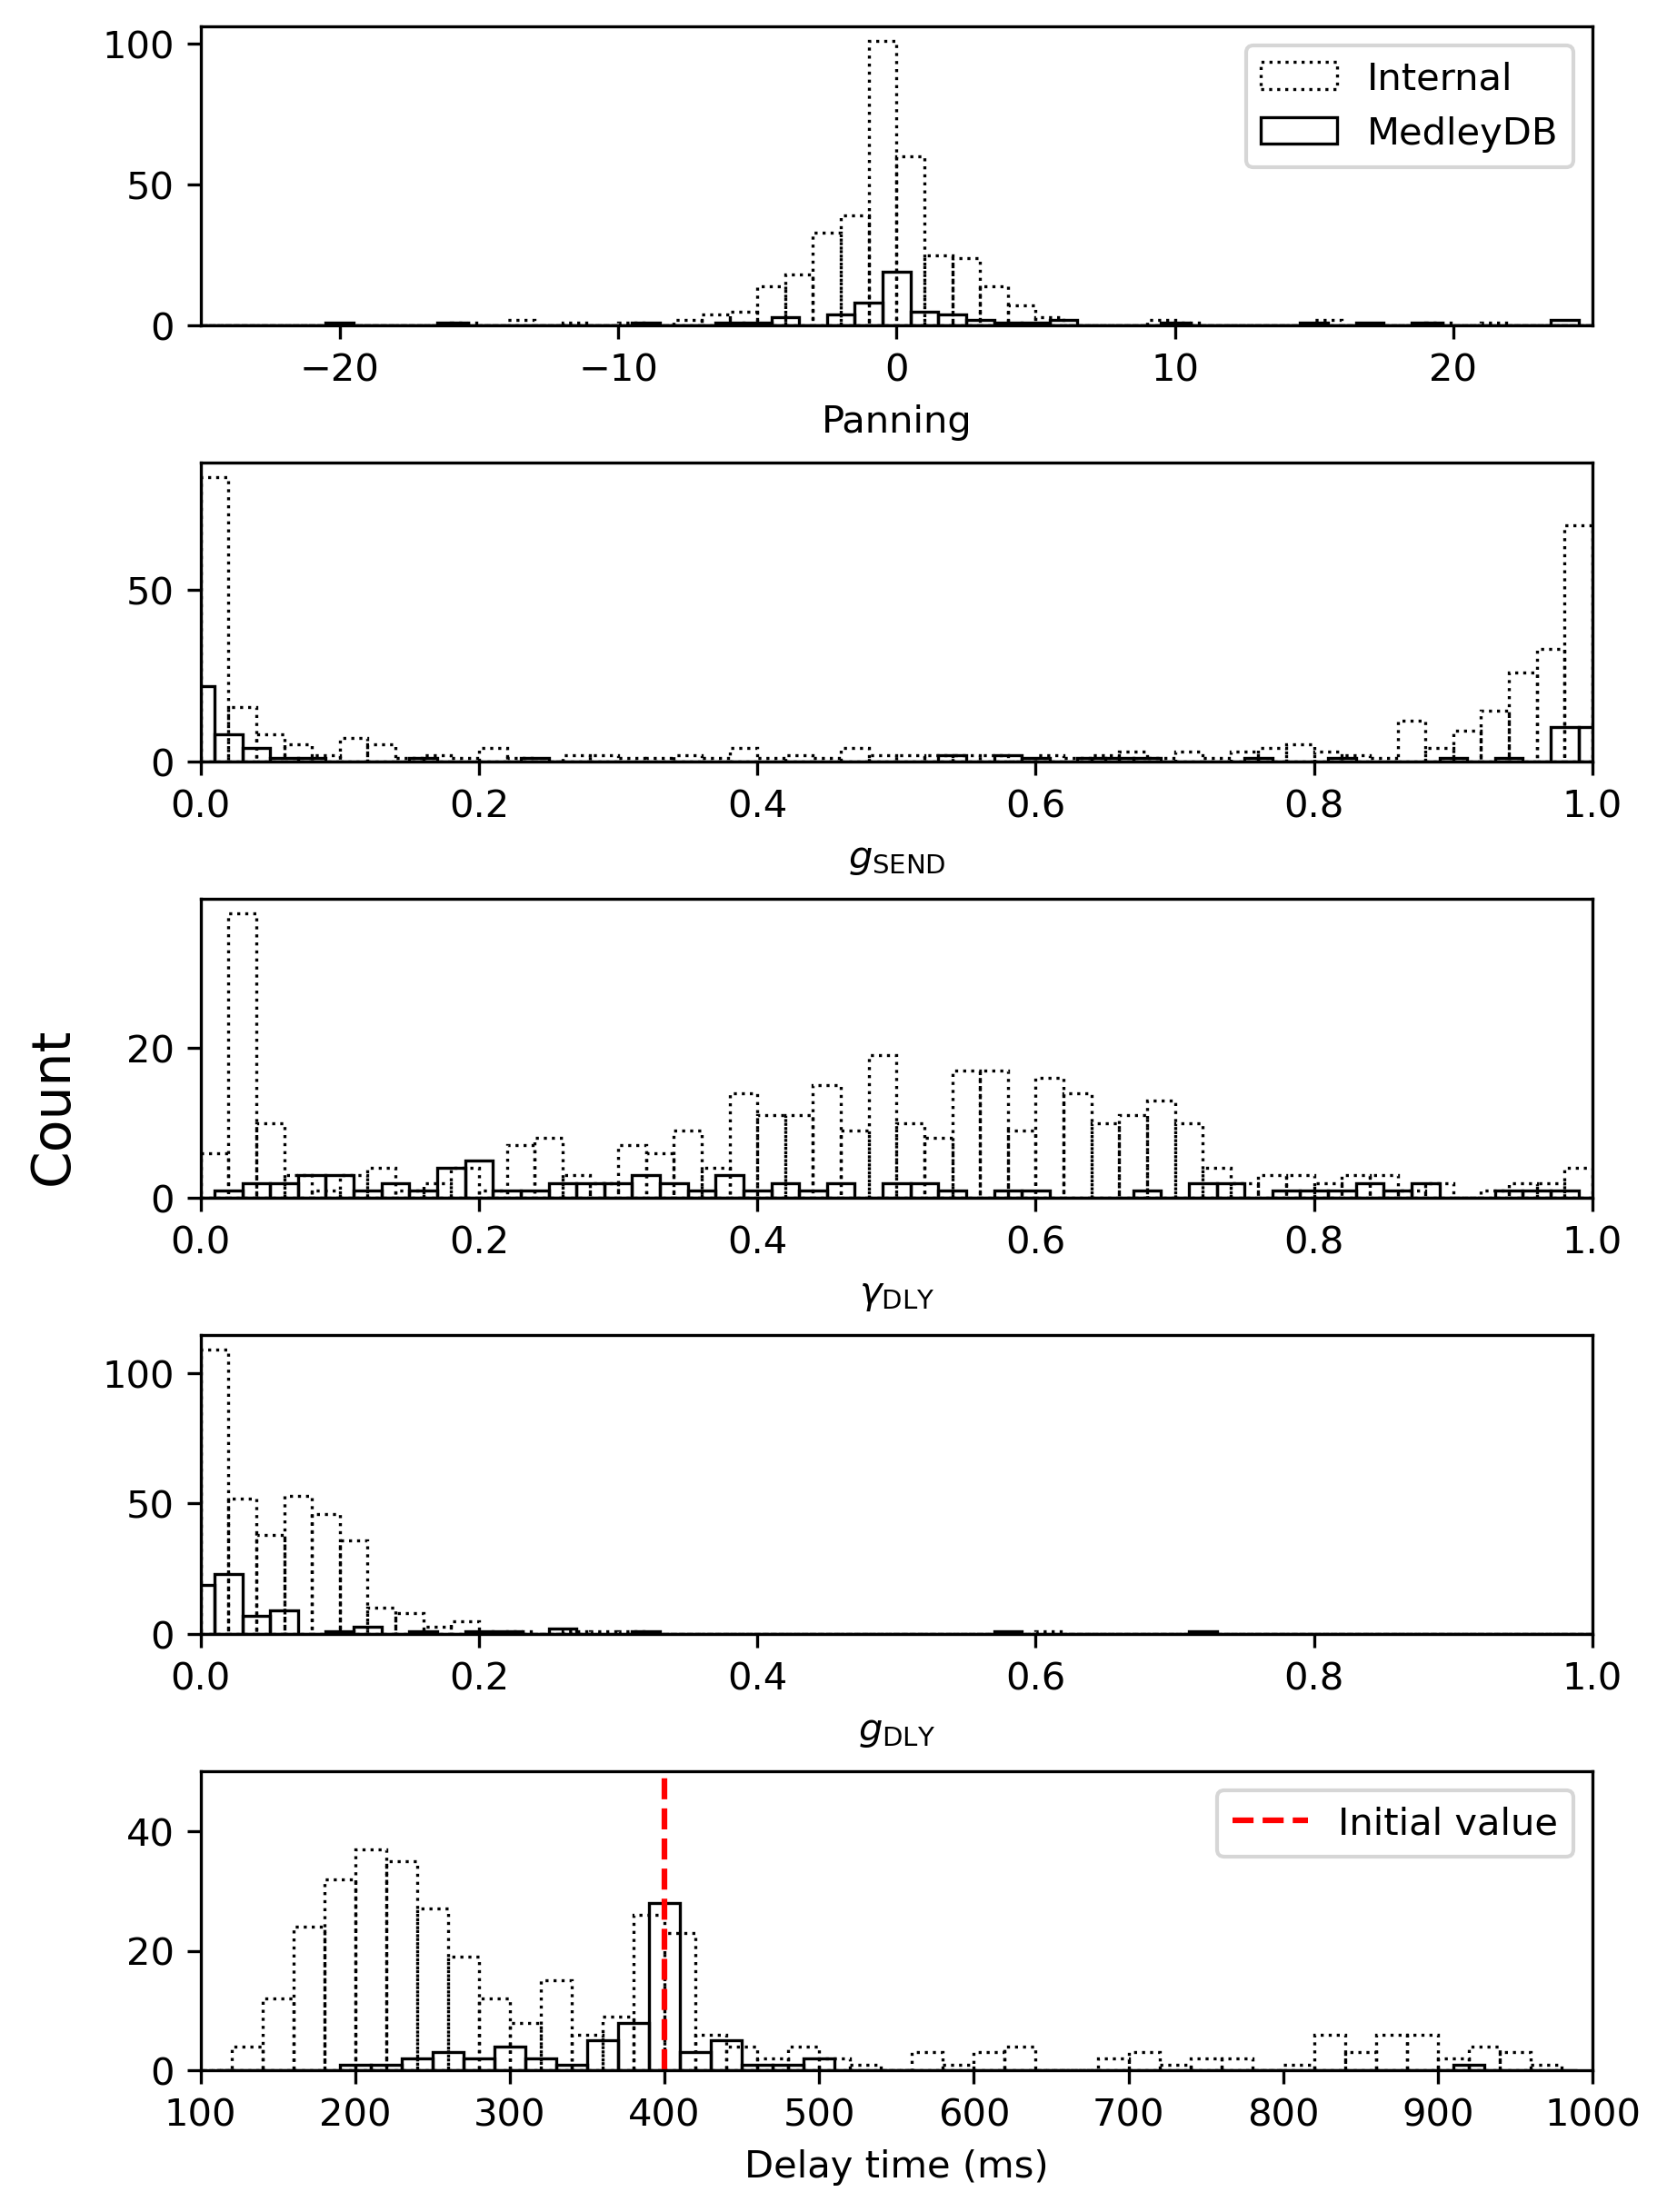

In [11]:
internal_pans = [model[7].pan.params.pan.item() * 200 - 100 for model in internal_models]
internal_sends = [m[7].params.sends_0.item() for m in internal_models]
medleydb_pans = [model[7].pan.params.pan.item() * 200 - 100 for model in medley_models]
medleydb_sends = [m[7].params.sends_0.item() for m in medley_models]
internal_delays = [m[7].effects[0].params.delay.item() for m in internal_models]
medleydb_delays = [m[7].effects[0].params.delay.item() for m in medley_models]
internal_feedbacks = [m[7].effects[0].params.feedback.item() for m in internal_models]
medleydb_feedbacks = [m[7].effects[0].params.feedback.item() for m in medley_models]
internal_delay_gains = [
    m[7].effects[0].params.gain.item() for m in internal_models
]
medleydb_delay_gains = [
    m[7].effects[0].params.gain.item() for m in medley_models
]

fig, ax = plt.subplots(5, 1, figsize=(6, 8), dpi=300, constrained_layout=True)

bins = np.arange(-100, 100, 1)

ax[0].hist(
    internal_pans, bins=bins, density=False, linestyle=":", label="Internal", **style
)
ax[0].hist(
    medleydb_pans,
    bins=bins + 0.5,
    density=False,
    linestyle="-",
    label="MedleyDB",
    **style
)
ax[0].set_xlim(-25, 25)
ax[0].set_xlabel("Panning")
ax[0].legend(loc="upper right")

bins = np.arange(-0.02, 1.01, 0.02)

ax[1].hist(
    internal_sends, bins=bins, density=False, linestyle=":", label="Internal", **style
)
ax[1].hist(
    medleydb_sends,
    bins=bins + 0.01,
    density=False,
    linestyle="-",
    label="MedleyDB",
    **style
)
ax[1].set_xlabel(r"$g_{\rm SEND}$")
ax[1].set_xlim(0, 1)

ax[2].hist(
    internal_feedbacks,
    bins=bins,
    density=False,
    linestyle=":",
    #   label="Internal",
    **style
)
ax[2].hist(
    medleydb_feedbacks,
    bins=bins + 0.01,
    density=False,
    linestyle="-",
    # label="MedleyDB",
    **style
)

ax[2].set_xlabel(r"$\gamma_{\rm DLY}$")
ax[2].set_xlim(0, 1)

ax[3].hist(
    internal_delay_gains,
    bins=bins,
    density=False,
    linestyle=":",
    #   label="Internal",
    **style
)
ax[3].hist(
    medleydb_delay_gains,
    bins=bins + 0.01,
    density=False,
    linestyle="-",
    # label="MedleyDB",
    **style
)
ax[3].set_xlabel(r"$g_{\rm DLY}$")
ax[3].set_xlim(0, 1)


bins = np.arange(100, 1000, 20)
ax[4].hist(
    internal_delays,
    bins=bins,
    density=False,
    linestyle=":",
    #   label="Internal",
    **style
)
ax[4].hist(
    medleydb_delays,
    bins=bins + 10,
    density=False,
    linestyle="-",
    # label="MedleyDB",
    **style
)
ax[4].set_xlabel(r"Delay time (ms)")
ax[4].set_xlim(100, 1000)
ax[4].set_ylim(0, 50)
ax[4].vlines(400, 0, 100, color="red", linestyle="--", label="Initial value")
ax[4].legend(loc="upper right")

fig.supylabel("Count", size=14)

plt.show()